# **Datathon - Model Challenge 2**

## **1. Preparing a DataFrame**

In [ ]:
import os
import pandas as pd

BASE_DIR = 'Dataset'

splits = ['train', 'validation']
labels = {'real': 1, 'fake': 0}
classes = ['animals', 'human_faces', 'vehicles']

data = []

for split in splits:
    for label_name, label_value in labels.items():
        for cls in classes:
            folder_path = os.path.join(BASE_DIR, split, label_name, cls)
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(folder_path, file)
                    data.append({
                        'full_path': full_path,
                        'label': label_value,
                        'class': cls,
                        'split': split
                    })

df = pd.DataFrame(data)

## **2. Preview of the Data**

In [35]:
print(df.head())
print(df.shape)

                                      full_path  label    class  split
0  Dataset\train\real\animals\animals_00001.jpg      1  animals  train
1  Dataset\train\real\animals\animals_00002.jpg      1  animals  train
2  Dataset\train\real\animals\animals_00003.jpg      1  animals  train
3  Dataset\train\real\animals\animals_00004.jpg      1  animals  train
4  Dataset\train\real\animals\animals_00005.jpg      1  animals  train
(227998, 4)


## **3. Exploratory Data Analysis**

### **Count of each class**

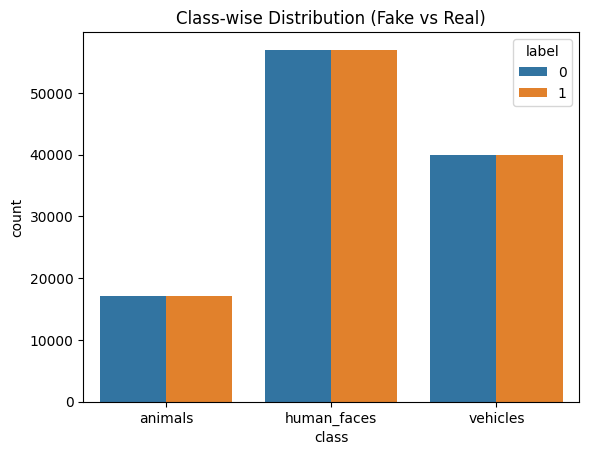

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='class', hue='label')
plt.title("Class-wise Distribution (Fake vs Real)")
plt.show()

## **Count by split**

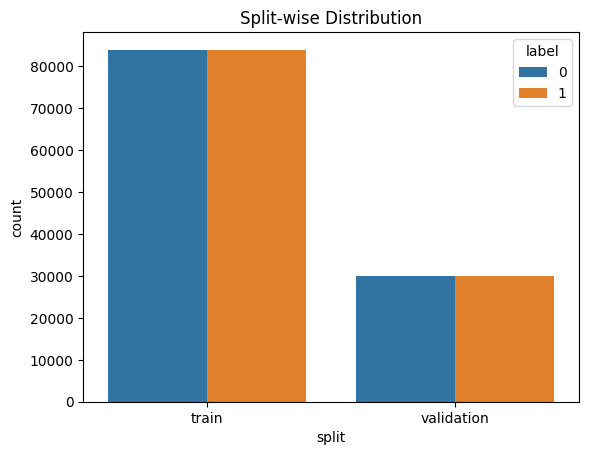

In [37]:
sns.countplot(data=df, x='split', hue='label')
plt.title("Split-wise Distribution")
plt.show()

## **Preprocessing of Dataset**

In [38]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

class_encoding = {'animals': 0, 'human_faces': 1, 'vehicles': 2}
df['class_encoded'] = df['class'].map(class_encoding)

image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['full_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.long)
        cls = torch.tensor(row['class_encoded'], dtype=torch.long)
        return image, label, cls

df_train = df[df['split'] == 'train']
df_val = df[df['split'] == 'validation']

train_dataset = DeepfakeDataset(df_train, transform=transform)
val_dataset = DeepfakeDataset(df_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## **Checking Class Imbalance** 

In [39]:
real_fake_counts = df_train['label'].value_counts()
print("Real vs Fake count (train):")
print(real_fake_counts)

class_counts = df_train['class_encoded'].value_counts()
print("\nClass distribution (train):")
print(class_counts)

weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float)

print("\nClass weights (real vs fake):", class_weights)

Real vs Fake count (train):
label
1    83999
0    83999
Name: count, dtype: int64

Class distribution (train):
class_encoded
1    84000
2    58798
0    25200
Name: count, dtype: int64

Class weights (real vs fake): tensor([1., 1.])


In [40]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# **Augmentation Transform**

In [41]:
from torchvision import transforms

image_size = 224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

## **Updating the Dataset Objects**

In [42]:
train_dataset = DeepfakeDataset(df_train, transform=train_transform)
val_dataset = DeepfakeDataset(df_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

## **Visualizing the Augmentations**

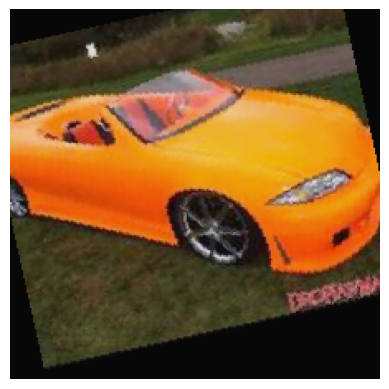

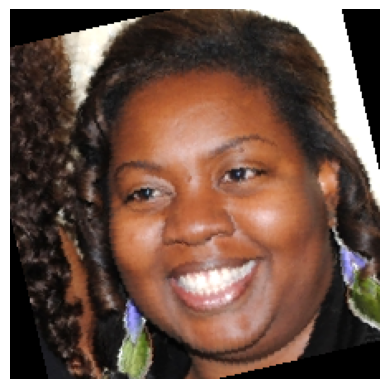

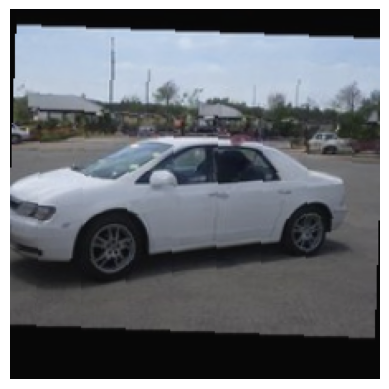

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

sample_df = df_train.sample(3)

for i, row in sample_df.iterrows():
    img = Image.open(row['full_path']).convert('RGB')
    img_aug = train_transform(img)
    imshow(img_aug)

# **Model Building**

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [45]:
class DualHeadResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super(DualHeadResNet18, self).__init__()
        self.base = models.resnet18(pretrained=pretrained)

        # Replace the final FC layer
        num_features = self.base.fc.in_features
        self.base.fc = nn.Identity()  # Remove original FC

        self.fc_binary = nn.Linear(num_features, 1)   # real/fake
        self.fc_class = nn.Linear(num_features, 3)    # class: animals, human_faces, vehicles

    def forward(self, x):
        features = self.base(x)
        binary_output = self.fc_binary(features).squeeze(1)  # shape: [batch]
        class_output = self.fc_class(features)               # shape: [batch, 3]
        return binary_output, class_output


In [46]:
model = DualHeadResNet18(pretrained=True)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Two losses: Binary + Multi-Class
criterion_binary = nn.BCEWithLogitsLoss()
criterion_class = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

C:\Users\Dhanush Srinivas\Desktop\Datathon-2025---shamrock\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dhanush Srinivas\Desktop\Datathon-2025---shamrock\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
best_val_loss = float('inf')
save_path = 'best_model.pt'

## **Training and Validation Loop**

In [48]:
import torch
from tqdm import tqdm

# Force to use GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("🚀 Using GPU:", torch.cuda.get_device_name(0))
else:
    raise RuntimeError("❌ GPU not available. Please enable CUDA.")

def train_model(model, train_loader, val_loader, epochs=10, patience=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion_binary = nn.BCEWithLogitsLoss()
    criterion_class = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_epoch = 0
    trigger_times = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # --- TRAINING ---
        model.train()
        train_loss = 0
        correct_binary, correct_class = 0, 0
        total = 0

        for images, labels, classes in tqdm(train_loader):
            images = images.to(device)
            labels = labels.float().to(device)
            classes = classes.to(device)

            optimizer.zero_grad()

            output_binary, output_class = model(images)

            loss1 = criterion_binary(output_binary, labels)
            loss2 = criterion_class(output_class, classes)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds_binary = (torch.sigmoid(output_binary) > 0.5).long()
            preds_class = output_class.argmax(dim=1)

            correct_binary += (preds_binary == labels.long()).sum().item()
            correct_class += (preds_class == classes).sum().item()
            total += labels.size(0)

        train_acc_bin = correct_binary / total
        train_acc_cls = correct_class / total
        print(f"Train Loss: {train_loss:.4f} | Binary Acc: {train_acc_bin:.4f} | Class Acc: {train_acc_cls:.4f}")

        # --- VALIDATION ---
        model.eval()
        val_loss = 0
        correct_binary, correct_class = 0, 0
        total = 0

        with torch.no_grad():
            for images, labels, classes in val_loader:
                images = images.to(device)
                labels = labels.float().to(device)
                classes = classes.to(device)

                output_binary, output_class = model(images)

                loss1 = criterion_binary(output_binary, labels)
                loss2 = criterion_class(output_class, classes)
                loss = loss1 + loss2

                val_loss += loss.item()

                preds_binary = (torch.sigmoid(output_binary) > 0.5).long()
                preds_class = output_class.argmax(dim=1)

                correct_binary += (preds_binary == labels.long()).sum().item()
                correct_class += (preds_class == classes).sum().item()
                total += labels.size(0)

        val_acc_bin = correct_binary / total
        val_acc_cls = correct_class / total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Val Loss: {avg_val_loss:.4f} | Binary Acc: {val_acc_bin:.4f} | Class Acc: {val_acc_cls:.4f}")

        # --- Early Stopping & Save ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("🔥 Best model saved!")
        else:
            trigger_times += 1
            print(f"Early stopping patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("⏹️ Early stopping triggered.")
                break

    print(f"\nTraining completed. Best model from epoch {best_epoch+1} saved.")

RuntimeError: ❌ GPU not available. Please enable CUDA.

In [ ]:
train_model(model, train_loader, val_loader, epochs=20, patience=4)